(256, 256)


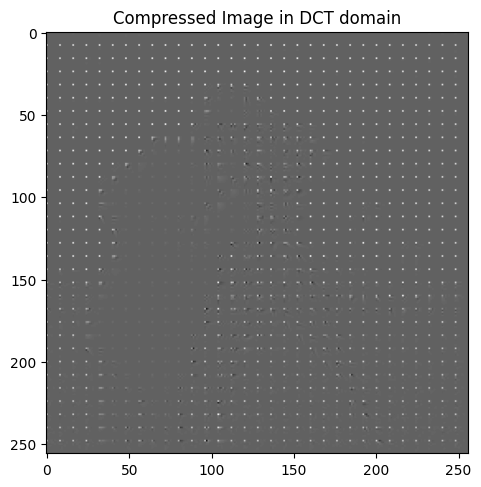

Compression Ratio : 9.064734245967966
Original Image Size in bits: 981330
Compressed Size (Custom) in bits: 108258


In [43]:
import skimage.io as io
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Load the image
original_image = io.imread('/content/drive/MyDrive/AIP/Assignment_4/cameraman.tif')

# Display the original image
io.imshow(original_image)
print(original_image.shape)

# Function to generate patches from the image
def patchify(image, h=8, w=8):
    for i in range(0, image.shape[0], h):
        for j in range(0, image.shape[1], w):
            yield image[i:i+h, j:j+w]

# Discrete Cosine Transform (DCT) function
def dct(n):
    c = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == 0:
                c[i, j] = np.sqrt(1/n)
            else:
                c[i, j] = np.sqrt(2/n) * np.cos((2*j+1) * i * np.pi / (2*n))
    return c

# Get patches and apply DCT
patch_list = list(patchify(original_image))
dct_compressed = []
for patch in patch_list:
    cosine_transform_matrix = dct(8)
    dct_compressed.append(cosine_transform_matrix @ patch @ cosine_transform_matrix.T)

# Quantization matrix
quantization_matrix = np.array([
     [16, 11, 10, 16, 24, 40, 51, 61],
     [12, 12, 14, 19, 26, 58, 60, 55],
     [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62],
     [18, 22, 37, 56, 68, 109, 103, 77],
     [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]])

# Compress the image using DCT and quantization
block_size = 8
dct_matrix = dct(block_size)
compressed_image = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(0, original_image.shape[0], block_size):
    for j in range(0, original_image.shape[1], block_size):
        compressed_image[i:i+block_size, j:j+block_size] = dct_matrix @ original_image[i:i+block_size, j:j+block_size] @ dct_matrix.T
        compressed_image[i:i+block_size, j:j+block_size] /= quantization_matrix

# Round the compressed image
compressed_image = np.floor(compressed_image + 0.5)

# Display the compressed image
plt.imshow(compressed_image, cmap='gray')
plt.title('Compressed Image in DCT domain')
plt.show()

# Function to encode the values
def encoding(value):
    steps = [0, 1, 3, 7, 15, 31, 63, 127, 255]
    value = int(value)
    code = 0
    if abs(value) == 0:
        code = 0
    else:
        for i in range(8):
            if steps[i] < abs(value) <= steps[i+1]:
                num = i + 1
                code = num * [1]
                code.append(0)
                if value > 0:
                    code.append((bin(abs(value))[2:]))
                else:
                    code.append((str(bin(steps[i + 1] + value)[2:]).rjust((i + 1), '0')))
                code = int(''.join(str(i) for i in code))
    return str(code)

# Encode the original image
encoded_original = ""
for i in range(original_image.shape[0]):
    for j in range(original_image.shape[1]):
        encoded_original = encoded_original + encoding(original_image[i, j])

# Encode the compressed image
encoded_compressed = ""
for i in range(original_image.shape[0]):
    for j in range(original_image.shape[1]):
        encoded_compressed = encoded_compressed + encoding(compressed_image[i, j])

# Calculate sizes and compression ratio (size in bits)
original_size = len(encoded_original)
compressed_size = len(encoded_compressed)
compression_ratio = original_size / compressed_size if compressed_size != 0 else float('inf')
print('Compression Ratio :', compression_ratio)
print('Original Image Size in bits:', original_size)
print('Compressed Size (Custom) in bits:', compressed_size)

# Save the compressed image
io.imsave('compressed.tif', compressed_image)


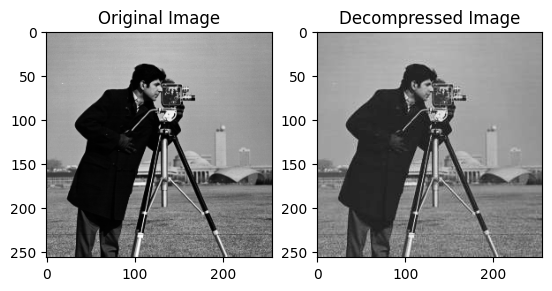

In [13]:
'''
# Decompression
xhat = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(0, original_image.shape[0], block_size):
    for j in range(0, original_image.shape[1], block_size):
        xhat[i:i+block_size, j:j+block_size] = compressed_image[i:i+block_size, j:j+block_size] * quantization_matrix
        xhat[i:i+block_size, j:j+block_size] = 0.25 * dct_matrix.T @ xhat[i:i+block_size, j:j+block_size] @ dct_matrix

# Display the decompressed image
plt.subplot(1, 2, 1)
plt.imshow(xhat, cmap='gray')
plt.title('Decompressed Image')'''

# Decompression
xhat = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(0, original_image.shape[0], block_size):
    for j in range(0, original_image.shape[1], block_size):
        xhat[i:i+block_size, j:j+block_size] = compressed_image[i:i+block_size, j:j+block_size] * quantization_matrix
        xhat[i:i+block_size, j:j+block_size] = dct_matrix.T @ xhat[i:i+block_size, j:j+block_size] @ dct_matrix

# Display the decompressed image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(xhat, cmap='gray')
plt.title('Decompressed Image')
plt.show()


In [6]:
def mse(original, reconstructed):
    """Compute Mean Squared Error (MSE) between original and reconstructed images."""
    return np.mean((original - reconstructed) ** 2)

def psnr(original, reconstructed):
    """Compute Peak Signal-to-Noise Ratio (PSNR) between original and reconstructed images."""
    max_pixel = np.max(original)
    return 20 * np.log10(max_pixel) - 10 * np.log10(mse(original, reconstructed))


In [36]:
# Calculate MSE
mse_custom = mse(original_image, xhat)
print('MSE custom:', mse_custom)



MSE custom: 44.54563508062465


In [56]:
import numpy as np
from PIL import Image

# Load the original image
original_image_path = '/content/drive/MyDrive/AIP/Assignment_4/cameraman.tif'
original_image = Image.open(original_image_path)

# Define the desired MSE
desired_mse = mse_custom  #

# Initialize quality parameter
quality = 95  # Starting quality value

# Loop until desired MSE is reached
while True:
    # Save the compressed image using the JPEG format
    compressed_image_path_def = f'/content/drive/MyDrive/AIP/Assignment_4/compressed_def_{quality}.jpg'
    original_image.save(compressed_image_path_def, quality=quality)

    # Reconstruct the compressed image
    reconstructed_image = Image.open(compressed_image_path_def).convert('L')

    # Convert the images to numpy arrays
    original_array = np.array(original_image)
    reconstructed_array = np.array(reconstructed_image)

    # Calculate the Mean Squared Error (MSE)
    mse_value = np.mean((original_array - reconstructed_array) ** 2)

    print(f'Quality: {quality}, MSE: {mse_value}')

    # Check if desired MSE is reached
    if mse_value >= desired_mse:
        print(f'Desired MSE of {desired_mse} reached with quality {quality}')
        break

    # Increment quality for the next iteration
    quality -= 5  # Adjust the increment/decrement value as needed


Quality: 95, MSE: 2.5084075927734375
Quality: 90, MSE: 6.628662109375
Quality: 85, MSE: 11.375625610351562
Quality: 80, MSE: 15.165740966796875
Quality: 75, MSE: 18.015350341796875
Quality: 70, MSE: 20.1827392578125
Quality: 65, MSE: 21.83953857421875
Quality: 60, MSE: 23.700576782226562
Quality: 55, MSE: 24.745071411132812
Quality: 50, MSE: 25.921218872070312
Quality: 45, MSE: 27.010787963867188
Quality: 40, MSE: 28.182647705078125
Quality: 35, MSE: 29.144210815429688
Quality: 30, MSE: 31.016830444335938
Quality: 25, MSE: 32.24180603027344
Quality: 20, MSE: 34.61067199707031
Quality: 15, MSE: 37.71612548828125
Quality: 10, MSE: 43.63078308105469
Quality: 5, MSE: 58.17604064941406
Desired MSE of 44.54563508062465 reached with quality 5


In [47]:
# Save the compressed image using the JPEG format for default compression
import os
compressed_image_path_default = '/content/drive/MyDrive/AIP/Assignment_4/compressed_def_final.jpg'
original_image.save(compressed_image_path_default, quality=quality)

# Get the compressed size for default compression
compressed_size_default = os.path.getsize(compressed_image_path_default)   # Size in bits
print(f'Custom Compression Compressed Size: {compressed_size} bits')
print(f'Default Compression - Quality: {quality}, Compressed Size: {compressed_size_default} bits')
compression_ratio_default = original_size / compressed_size_default if compressed_size_default != 0 else float('inf')
print(f'Compression ratio using default: {compression_ratio_default}')

print('MSE:',desired_mse)

Custom Compression Compressed Size: 108258 bits
Default Compression - Quality: 5, Compressed Size: 1945 bits
Compression ratio using default: 504.5398457583548
MSE: 44.54563508062465


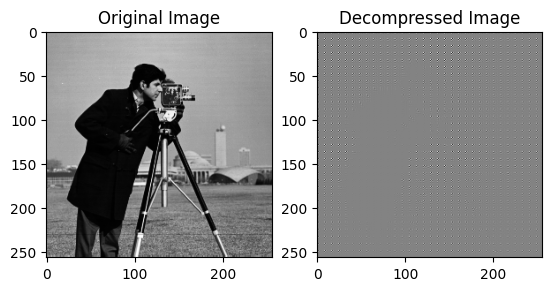

In [55]:
import matplotlib.pyplot as plt

# Load the original, custom compressed, and default compressed images
original_image = io.imread('/content/drive/MyDrive/AIP/Assignment_4/cameraman.tif')
custom_compressed_image = io.imread('/content/compressed.tif')
default_compressed_image = io.imread('/content/drive/MyDrive/AIP/Assignment_4/compressed_def_final.jpg')

# Display the images
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Custom compressed image
plt.subplot(1, 3, 2)
plt.imshow(custom_compressed_image, cmap='gray')
plt.title('Custom Compressed Image')
plt.axis('off')

# Default compressed image
plt.subplot(1, 3, 3)
plt.imshow(default_compressed_image, cmap='gray')
plt.title('Default Compressed Image')
plt.axis('off')

plt.show()

xhat1 = np.zeros((256, 256))

for i in range(0, 256, block_size):
    for j in range(0, 256, block_size):
        xhat1[i:i+block_size, j:j+block_size] = default_compressed_image[i:i+block_size, j:j+block_size] * quantization_matrix
        xhat1[i:i+block_size, j:j+block_size] = dct_matrix.T @ xhat1[i:i+block_size, j:j+block_size] @ dct_matrix
# Display the decompressed image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(xhat1, cmap='gray')
plt.title('Decompressed Image')
plt.show()
